# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
from ipywidgets import widgets

#setting cufflinks to link iplot() method to df
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
import spacy
from spacymoji import Emoji
from nltk.corpus import stopwords, words
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer as lemmatize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import pyLDAvis.gensim

from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer, CorpusFromParsedDocuments, Scalers
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
df = pd.read_csv('../data/cleaned_reviews.csv')

In [3]:
df.head()

rating                 date      app   store  \
0       5  2020-09-16 20:26:28  shoppee  google   
1       4  2020-09-16 20:13:46  shoppee  google   
2       5  2020-09-16 20:13:05  shoppee  google   
3       4  2020-09-16 20:11:18  shoppee  google   
4       5  2020-09-16 20:08:54  shoppee  google   

                                              review  \
0    Orders mostly came early and products are good.   
1                                Good and convenient   
2                                      Gd...........   
3  My first purchase experience...Happy with purc...   
4                A lot of items at a very good deal.   

                        clean_content               adj  \
0       order come early product good             good    
1                     good convenient  good convenient    
2                                 NaN               NaN   
3  purchase experience happy purchase      first happy    
4                  lot item good deal             good    

                            noun   verb emoji  neg_score  neu_score  \
0                 order product   come    NaN        0.0      0.707   
1                            NaN    NaN   NaN        0.0      0.408   
2                            NaN    NaN   NaN        0.0      1.000   
3  purchase experience purchase     NaN   NaN        0.0      0.714   
4                 lot item deal     NaN   NaN        0.0      0.715   

   pos_score  compound_score  
0      0.293          0.4404  
1      0.592          0.4404  
2      0.000          0.0000  
3      0.286          0.3400  
4      0.285          0.4927

In [4]:
df.shape

(78934, 14)

# Removing null values

In [5]:
df.isna().sum()[df.isna().sum() != 0]

review               5
clean_content     4249
adj              18158
noun             25522
verb             35821
emoji            73156
dtype: int64

In [6]:
df= df[df['clean_content'].notna()]
df.reset_index(inplace = True, drop = True)

In [7]:
df.isna().sum()[df.isna().sum() != 0]

adj      14433
noun     22056
verb     31922
emoji    69984
dtype: int64

In [8]:
print(f'Number of rows entry in data: {df.shape[0]}')

Number of rows entry in data: 74685


In [9]:
df.notna().sum()[df.notna().sum() != df.shape[0]]

adj      60252
noun     52629
verb     42763
emoji     4701
dtype: int64

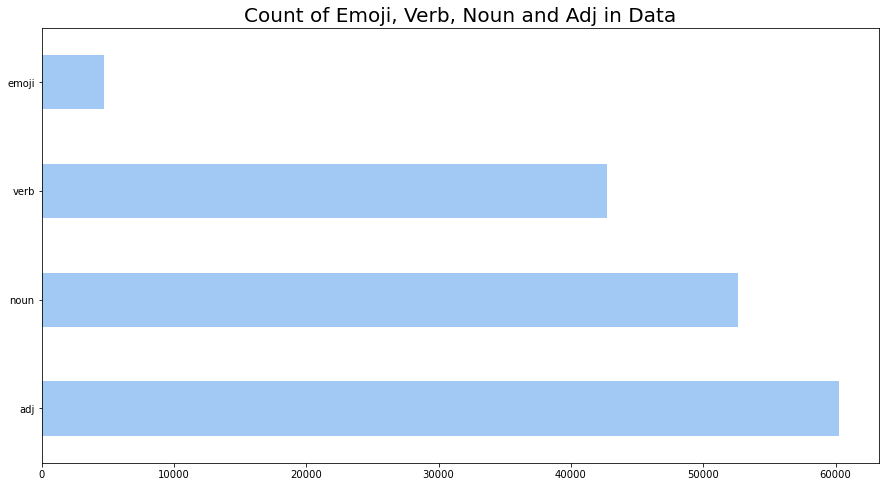

In [10]:
plt.figure(figsize = (15, 8))
plt.title('Count of Emoji, Verb, Noun and Adj in Data', fontsize = 20)
df.notna().sum()[df.notna().sum() != df.shape[0]].plot(kind = 'barh');

**Remarks**
- There is very little reviews that uses Emoji, which means we cannot rely heavily on emojis to do the prediction, however, we will still add it into the model

## Changing Date Data to datetime dtype

In [11]:
df['date'] = df['date'].astype('datetime64')

## Creating new columns for eda

### New time columns

In [12]:
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek + 1 #adding 1 as the data starts from 0 for monday, this is to avoid confusion
df['hour'] = df.date.dt.hour
df['minute'] = df.date.dt.minute

### Length of text columns

In [13]:
df['text_len'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

# EDA

## Distribution of App, Rating, Store, Month and DayofWeek

In [14]:
def plot_countplots(df, features):
    nrows = int(np.ceil(len(features)/2))
    fig, ax = plt.subplots(nrows, 2, figsize=(18,6*nrows))
    ax = ax.ravel()
    for i in range(len(features)):
        ax[i].set_title(f'Count of {features[i]} across Shopping reviews', fontdict = {'fontsize': 10})
        sns.countplot(x = features[i], data = df, ax = ax[i]);

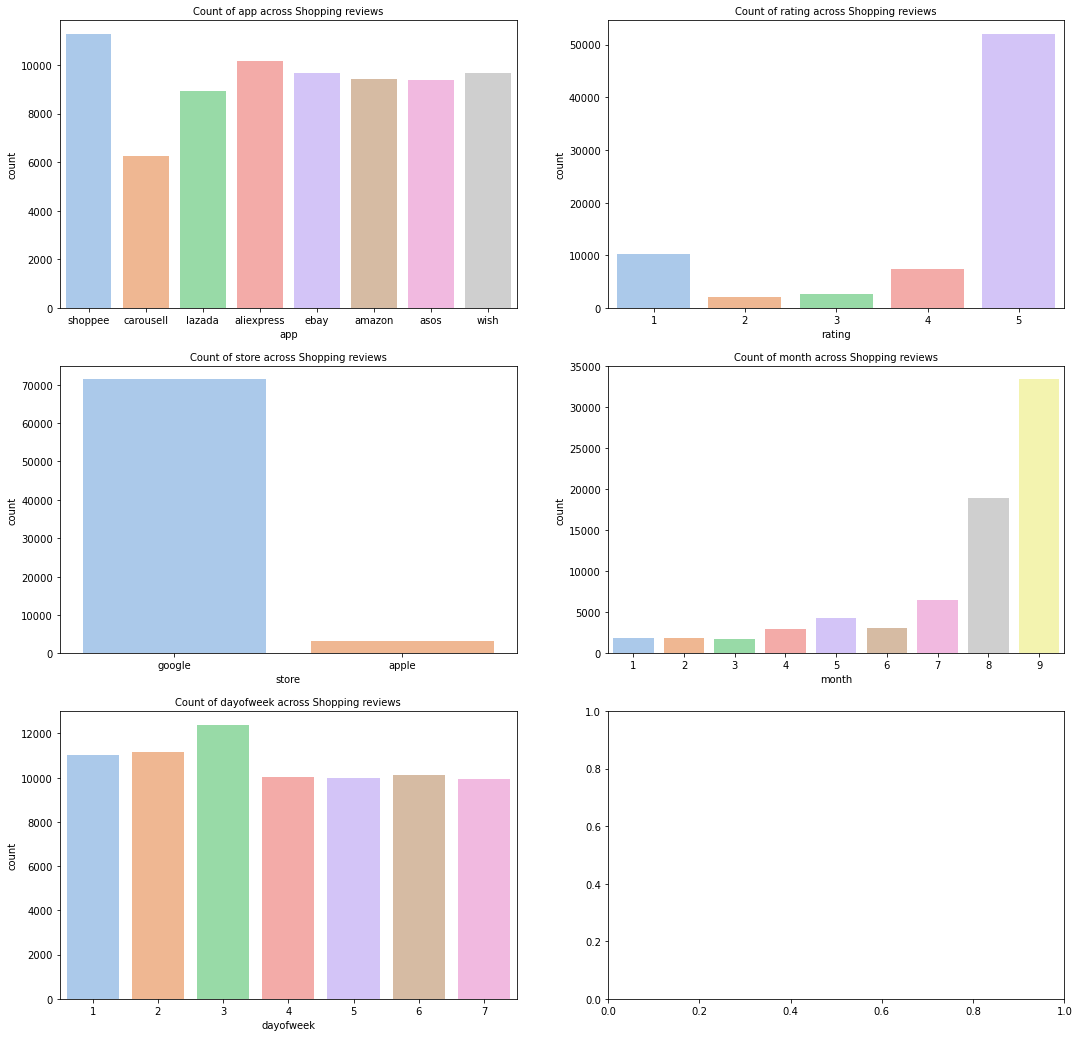

In [15]:
plot_countplots(df, ['app', 'rating', 'store', 'month', 'dayofweek'])

**Remarks**
- There is a imbalance data in the ratings, with significantly more positive reviews as compared to negative reviews
- There is more reviews data in the September month as compared to the earlier period, which is due to the data collection period
- Interestingly, there is more reviews on Wednesday as compared to other days

## Boxplot of App across Month

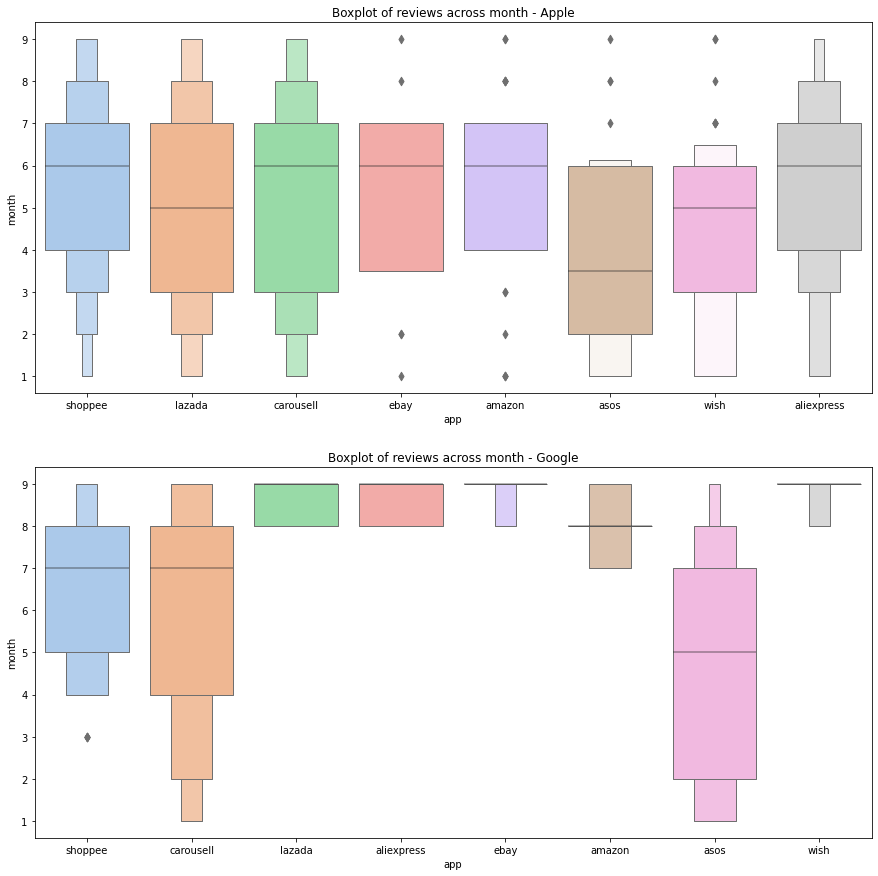

In [16]:
fig,ax = plt.subplots(2,1, figsize = (15, 15))
ax[0].set_title('Boxplot of reviews across month - Apple')
sns.boxenplot(x = 'app', y = 'month', data = df[df['store'] == 'apple'], ax = ax[0])

ax[1].set_title('Boxplot of reviews across month - Google')
sns.boxenplot(x = 'app', y = 'month', data = df[df['store'] == 'google'], ax = ax[1]);

**Remarks**
- The data collected is more spread across the time period in Apple Appstore as compared to Google Playstore

## TimeSeries Analysis of Data

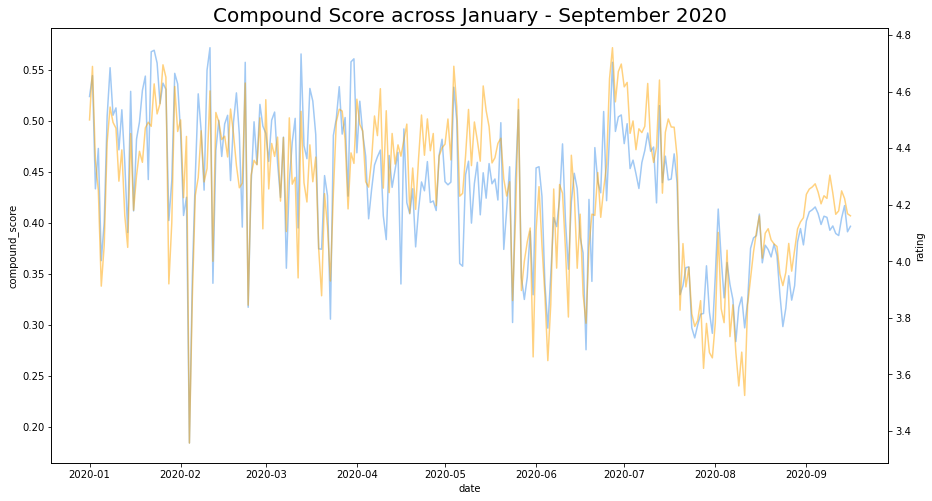

In [17]:
plt.figure(figsize = (15,8))
plt.title('Compound Score across January - September 2020', fontsize = 20)
ax = sns.lineplot(x = 'date' , y = 'compound_score', data = df.resample('D', on = 'date').mean())
g2 = ax.twinx()
sns.lineplot(x = 'date' , y = 'rating', data = df.resample('D', on = 'date').mean(), ax = g2, color = 'orange', alpha = 0.5);

**Remarks**
- The compound score from VaderSentiment and ratings are closely similar, therefore will use compound score for certain visualisation

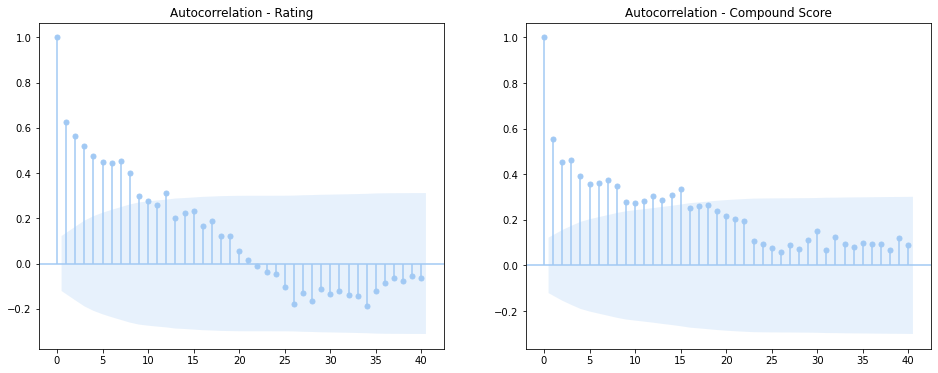

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_acf(df.resample('D', on = 'date').mean()['rating'], lags = 40, ax = ax[0], title = 'Autocorrelation - Rating')
plot_acf(df.resample('D', on = 'date').mean()['compound_score'], lags = 40, ax = ax[1], title = 'Autocorrelation - Compound Score');

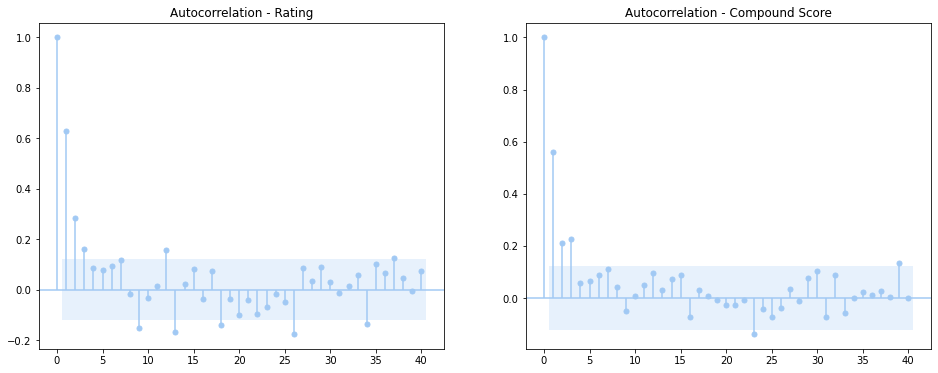

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_pacf(df.resample('D', on = 'date').mean()['rating'], lags = 40, ax = ax[0], title = 'Autocorrelation - Rating')
plot_pacf(df.resample('D', on = 'date').mean()['compound_score'], lags = 40, ax = ax[1], title = 'Autocorrelation - Compound Score');

**Remarks**
- from the plots above, it can be interpreted that there is a seasonality of 1 week(7days), and around 1 month(26, 28 days)

## Distribution by Hour, DayofWeek

In [20]:
def plot_countplots_time(df, date_features, scoring):
    nrows = int(np.ceil(len(date_features)))
    fig,ax = plt.subplots(nrows,1, figsize = (15, 6*nrows))
    
    for i in range(len(date_features)):
        ax[i].set_title(f'Count of {date_features[i]} across Shopping reviews {scoring}', fontdict = {'fontsize': 20})
        g = sns.countplot(x = date_features[i] , data = df, ax=ax[i])
        g2 = g.twinx()
        
        g2 = sns.pointplot(x = date_features[i],
                           y = scoring, 
                           data = df ,
                           ax=g2, color = 'black')
        
        plt.legend(labels = [f'{scoring} mean'])
    plt.show()

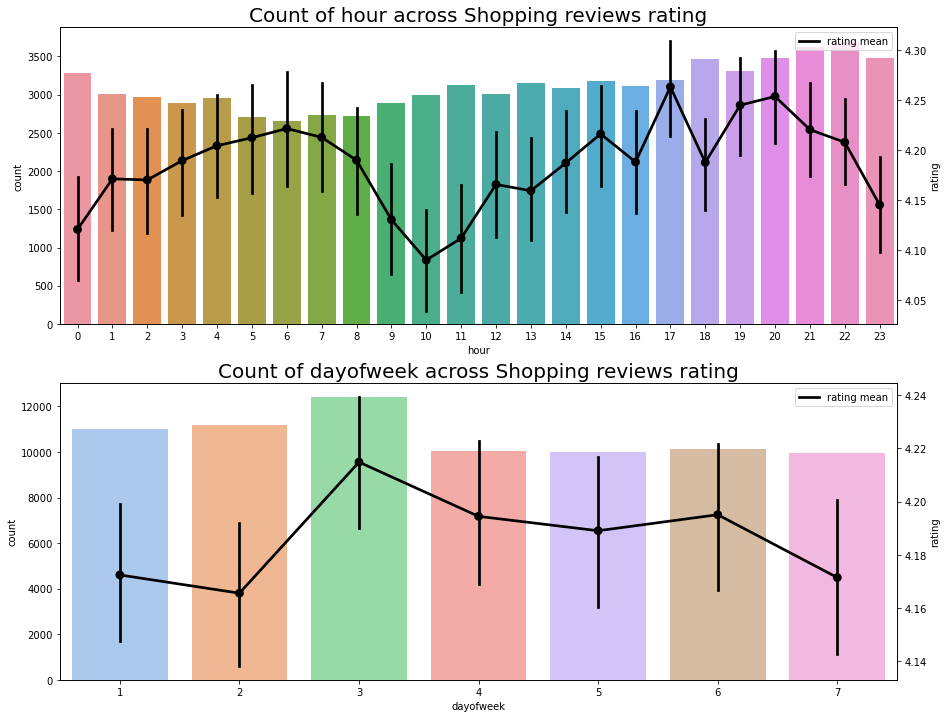

In [21]:
plot_countplots_time(df, ['hour', 'dayofweek'], 'rating')

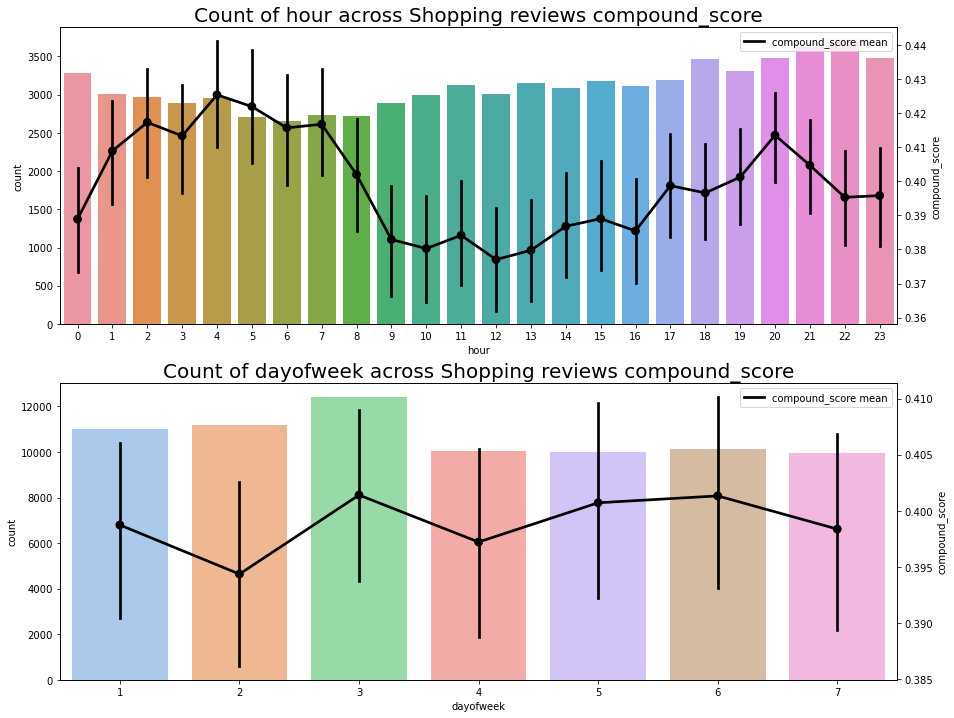

In [22]:
plot_countplots_time(df, ['hour', 'dayofweek'], 'compound_score')

**Remarks**
- More negative reviews are seen in 9am - 3pm period
- More negative reviews in Tuesdays

## Distribution of Wordlen, Wordcount

In [23]:
def dist_plotting(features):
    nrows = len(features)
    fig, ax = plt.subplots(nrows,1, figsize = (15, 6*nrows))
    plt.subplots_adjust(hspace = 0.2)
    
    for i in range(len(features)):
        ax[i].set_title(f'Distribution of {features[i]} of reviews')
        sns.histplot(data = df[df['rating'] > 3], x = features[i], color = 'b', ax = ax[i], label = 'good_review')
        sns.histplot(data = df[df['rating'] <= 3], x = features[i], alpha = 0.7, ax = ax[i], color = 'r', label = 'bad_review')
        ax[i].set_xlim([0,df[features[i]].quantile(q = 0.99)])
        ax[i].legend()

Average text length of good reviews: 51
Average text length of bad reviews: 160
Average word count of good reviews: 9
Average word count of bad reviews: 29


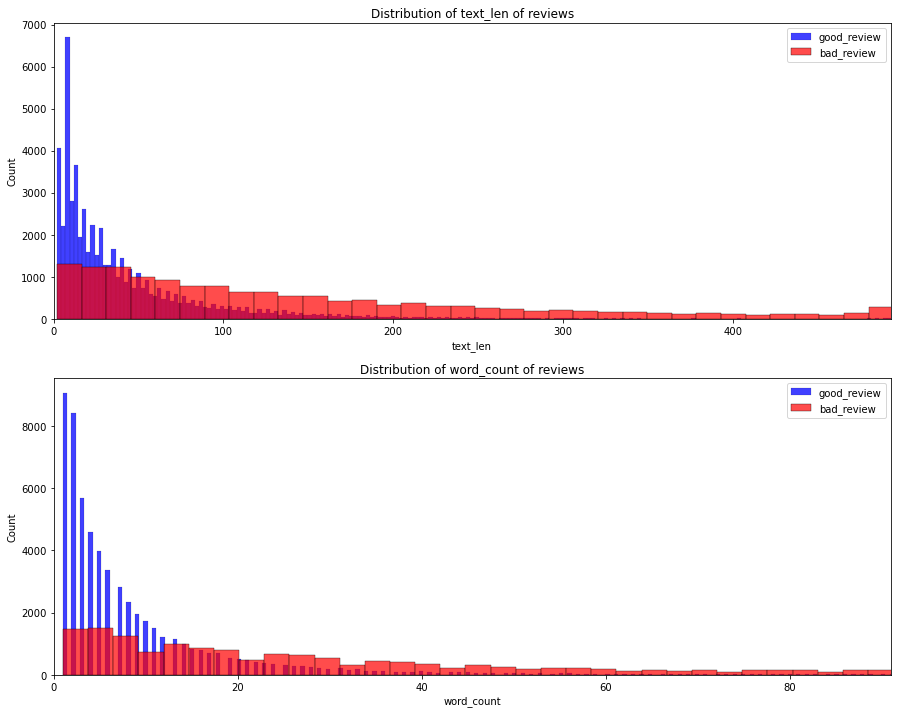

In [24]:
print(f'Average text length of good reviews: {round(df.text_len[df.rating > 3].mean())}')
print(f'Average text length of bad reviews: {round(df.text_len[df.rating <= 3].mean())}')
print(f'Average word count of good reviews: {round(df.word_count[df.rating > 3].mean())}')
print(f'Average word count of bad reviews: {round(df.word_count[df.rating <= 3].mean())}')

dist_plotting(['text_len', 'word_count'])

**Remarks**
- Bad reviews tend to have more word count as compared to good reviews

## Distribution of Adj, Noun, Verb and Emoji

In [25]:
def dist_plotting_word(features):
    nrows = len(features)
    fig, ax = plt.subplots(nrows,1, figsize = (15, 5*nrows))
    plt.subplots_adjust(hspace = 0.4)
    
    for i in range(len(features)):
        ax[i].set_title(f'Distribution of {features[i]} of reviews')
        sns.histplot(data = df[df['rating'] > 3], x = round(df[df['rating'] > 3][features[i]].str.len()), color = 'b', ax = ax[i], label = 'good_review')
        sns.histplot(data = df[df['rating'] <= 3], x = round(df[df['rating'] <= 3][features[i]].str.len()), alpha = 0.7, ax = ax[i], color = 'r', label = 'bad_review')
        ax[i].set_xlim([0,round(df[df['rating'] > 3][features[i]].str.len()).quantile(q = 0.99)])
        ax[i].legend()

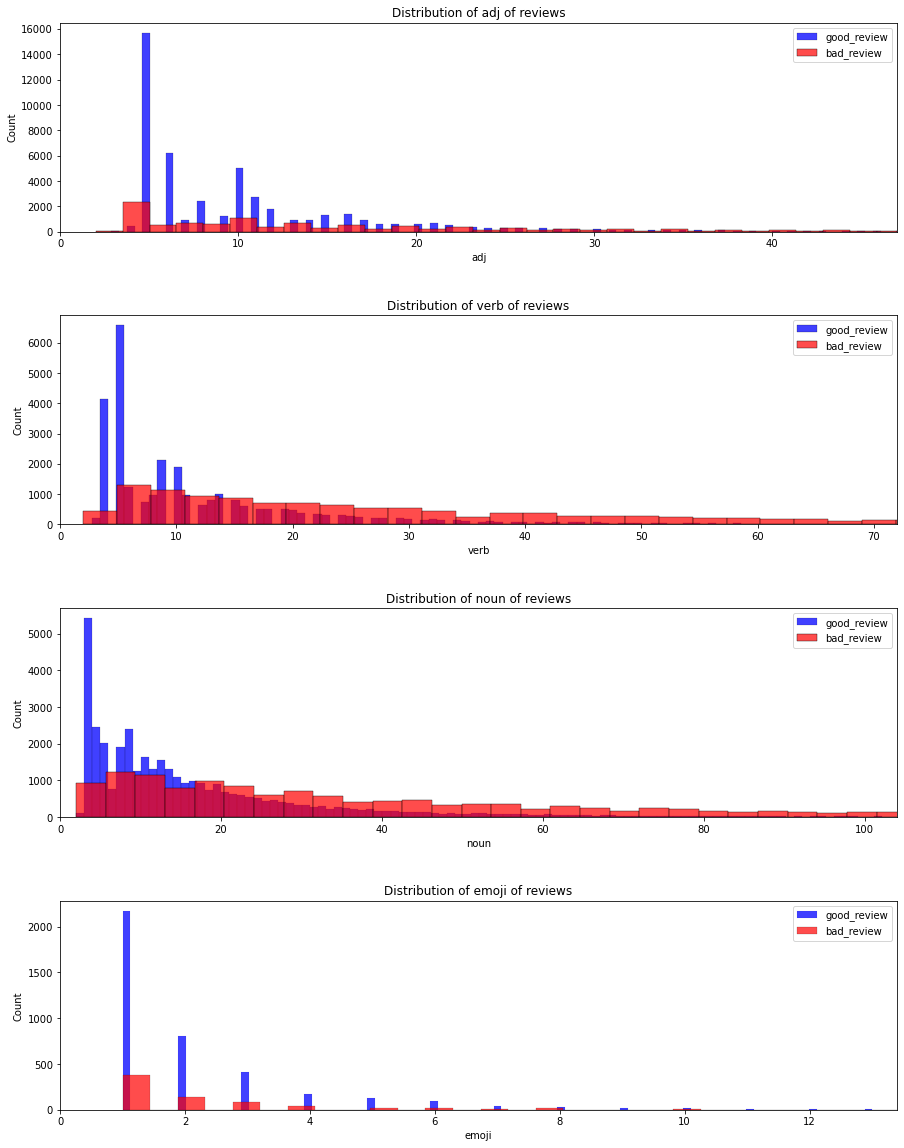

In [26]:
dist_plotting_word(['adj', 'verb', 'noun', 'emoji'])

## Boxplot of Rating across apps

In [27]:
def boxplot_interact(scoring):
    
    y0 = df.loc[df['app'] == 'shoppee'][scoring]
    y1 = df.loc[df['app'] == 'carousell'][scoring]
    y2 = df.loc[df['app'] == 'lazada'][scoring]
    y3 = df.loc[df['app'] == 'aliexpress'][scoring]
    y4 = df.loc[df['app'] == 'ebay'][scoring]
    y5 = df.loc[df['app'] == 'amazon'][scoring]
    y6 = df.loc[df['app'] == 'asos'][scoring]
    y7 = df.loc[df['app'] == 'wish'][scoring]
    
    trace0 = go.Box(y=y0,name = 'shoppee',marker = dict(color = 'rgb(214, 12, 140)',))
    trace1 = go.Box(y=y1,name = 'carousell',marker = dict(color = 'rgb(0, 128, 128)',))
    trace2 = go.Box(y=y2,name = 'lazada',marker = dict(color = 'rgb(10, 140, 208)',))
    trace3 = go.Box(y=y3,name = 'aliexpress',marker = dict(color = 'rgb(12, 102, 14)',))
    trace4 = go.Box(y=y4,name = 'ebay',marker = dict(color = 'rgb(10, 0, 100)',))
    trace5 = go.Box(y=y5,name = 'amazon', marker = dict(color = 'rgb(100, 0, 10)',))
    trace6 = go.Box(y=y6,name = 'asos',marker = dict(color = 'rgb(255, 212, 59)',))
    trace7 = go.Box(y=y7,name = 'wish',marker = dict(color = 'rgb(100, 100, 100)',))
    
    data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
    
    layout = go.Layout(title = f"Sentiment {scoring} Boxplot of app")
                    
    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(autosize=False,width=1000,height=500,
                      margin=dict(l=50,r=50,b=100,t=100,pad=4),paper_bgcolor="white")
    
    iplot(fig, filename = f'Sentiment {scoring} Boxplot of app', image_width=600, image_height=400,)

In [28]:
boxplot_interact('rating')

## Boxplot of Compound score across apps

In [29]:
boxplot_interact('compound_score')

## Distribution of Keywords

In [30]:
def get_top_n_words(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer().fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

### Good Reviews

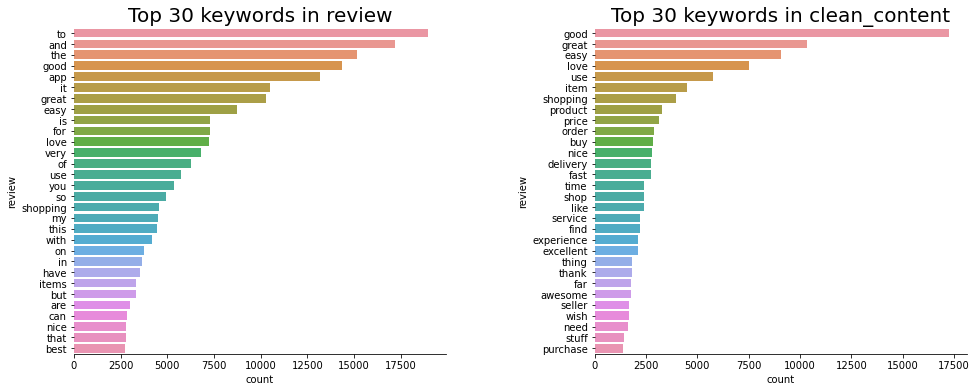

In [31]:
get_top_n_words(df[df['rating'] > 3], ['review', 'clean_content'], 30)

### Bad Reviews

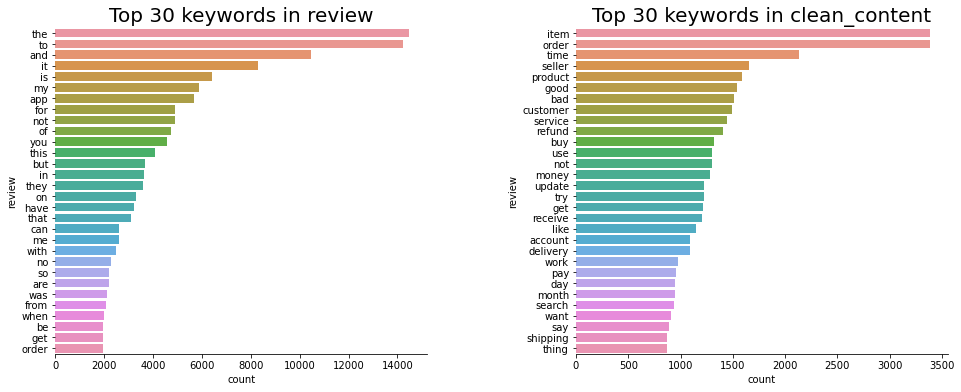

In [32]:
get_top_n_words(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

**Remarks**
- Keywords in the top chart are good, great,easy, use
- keywords in the bad reviews top chart are time, order, service

## Distribution of Bigram Keywords

In [33]:
def get_top_n_bigrams(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer(ngram_range=(2, 2)).fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} Bigrams keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

### Good Reviews

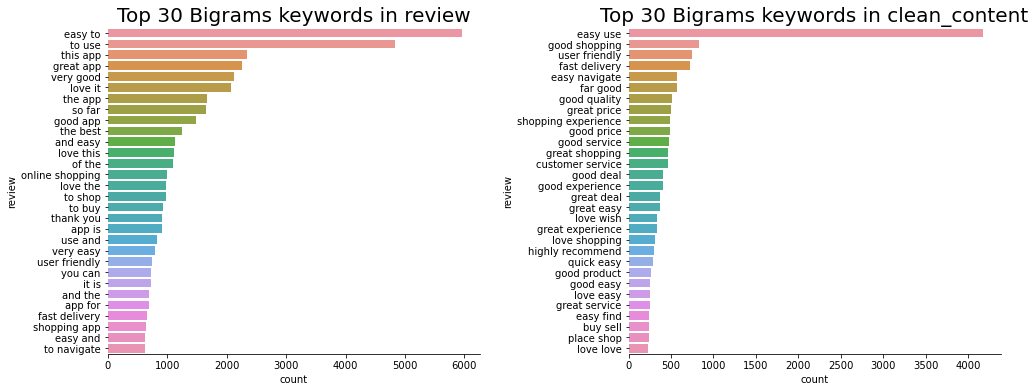

In [34]:
get_top_n_bigrams(df[df['rating'] > 3], ['review', 'clean_content'], 30)

### Bad Reviews

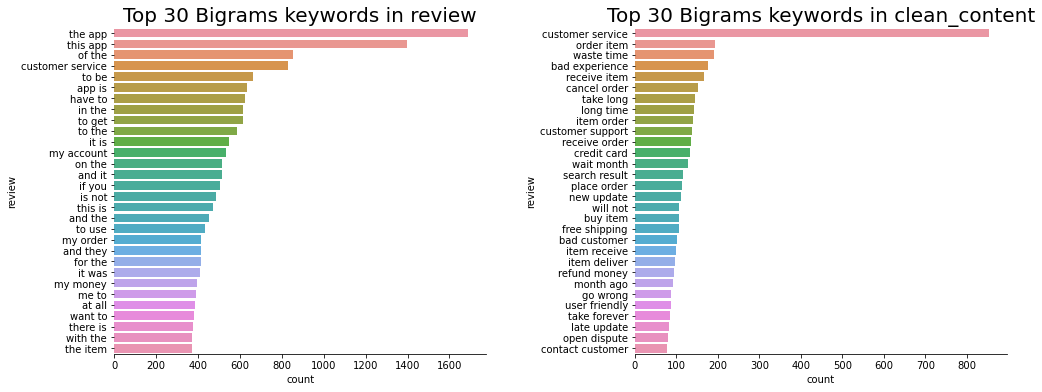

In [35]:
get_top_n_bigrams(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

**Remarks**
- looking at the bigrams, Customer service seems to be very important factor in giving a bad review
- whereas 'Easy Use' came up as top for good review, which need further reasearch to see what it means

## Distribution of Trigram Keywords

In [36]:
def get_top_n_trigrams(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer(ngram_range=(3, 3)).fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} Trigram keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

### Good Reviews

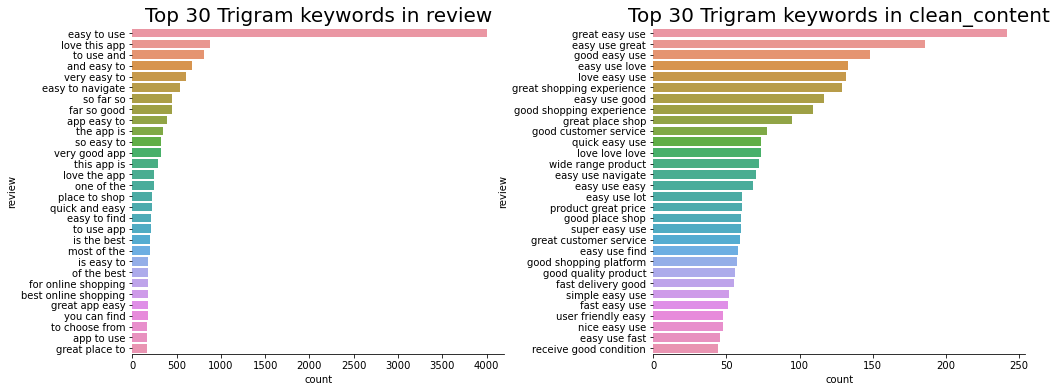

In [37]:
get_top_n_trigrams(df[df['rating'] > 3], ['review', 'clean_content'], 30)

### Bad Reviews

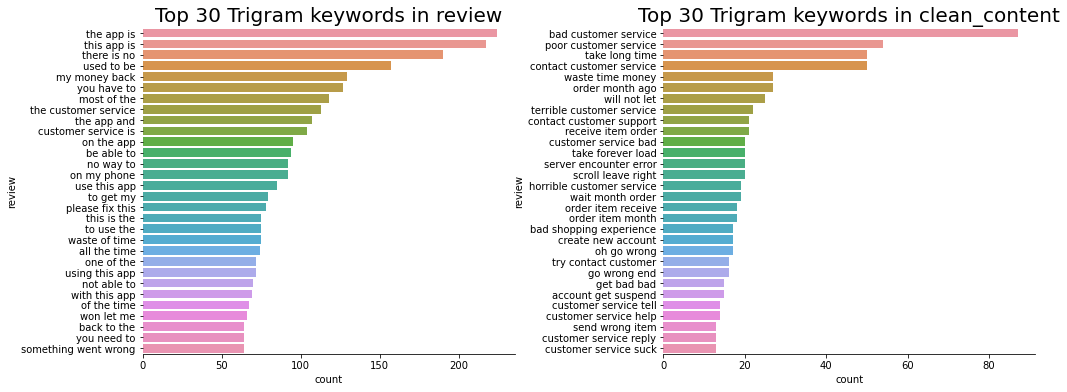

In [38]:
get_top_n_trigrams(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

**Remarks**
- Similar to the bigrams plot, Customer Service and Easy use seems to be at the top 

## Extra: Interactive plot of ratings

In [39]:
month = widgets.IntSlider(value=1.0,min=1.0,max=9.0,step=1.0,
                          description='Month:',continuous_update=False)

use_date = widgets.Checkbox(description='Date: ',value=True,)

container = widgets.HBox(children=[use_date, month])

store = widgets.Dropdown(description='Store:   ',value='apple',
                         options=df['store'].unique().tolist())

app = widgets.Dropdown(options=list(df['app'].unique()),
                       value='shoppee',description='App:',)


goodrtrace = go.Histogram(x=df[df['rating'] > 3]['rating'], opacity=0.75, name='Good reviews')
badrtrace = go.Histogram(x=df[df['rating'] <= 3]['rating'], opacity=0.75, name='Bad reviews')
inter = go.FigureWidget(data=[goodrtrace, badrtrace],
                    layout=go.Layout(
                        title=dict(
                            text='Apps Ratings'
                        ),
                        barmode='overlay'
                    ))
inter.update_layout(autosize=False,width=1000,height=500,
                margin=dict(l=50,r=50, b=100,t=100,pad=4),
                paper_bgcolor="white",);

In [40]:
def validate():
    if app.value in df['app'].unique() and store.value in df['store'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        if use_date.value:
            filter_list = [i and j and k for i, j, k in
                           zip(df['month'] == month.value, df['store'] == store.value,
                               df['app'] == app.value)]
            temp_df = df[filter_list]

        else:
            filter_list = [i and j for i, j in
                           zip(df['store'] == 'apple', df['app'] == app.value)]
            temp_df = df[filter_list]
        x1 = temp_df[temp_df['rating'] > 3]['rating']
        x2 = temp_df[temp_df['rating'] <= 3]['rating']
        with inter.batch_update():
            inter.data[0].x = x1
            inter.data[1].x = x2
            inter.layout.barmode = 'overlay'
            inter.layout.xaxis.title = 'Ratings'
            inter.layout.yaxis.title = 'Number of Reviews'


app.observe(response, names="value")
store.observe(response, names="value")
month.observe(response, names="value")
use_date.observe(response, names="value")

In [41]:
container2 = widgets.HBox([app, store])
display(widgets.VBox([container,container2,inter]))

# Topic Modeling for above average ratings (4, 5 ratings )

## Converting to list

In [42]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df[df['rating'] > 3].clean_content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['order', 'come', 'early', 'product', 'good']]


## LDA Modelling

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           chunksize = 4000,
                                           passes = 10,
                                           alpha = 'asymmetric')

pprint(lda_model.print_topics())

[(0,
  '0.126*"good" + 0.098*"great" + 0.078*"love" + 0.077*"easy" + 0.048*"use" + '
  '0.032*"shopping" + 0.030*"price" + 0.020*"fast" + 0.019*"product" + '
  '0.018*"service"'),
 (1,
  '0.042*"item" + 0.029*"order" + 0.027*"wish" + 0.023*"buy" + 0.022*"time" + '
  '0.022*"like" + 0.018*"thing" + 0.013*"product" + 0.012*"seller" + '
  '0.012*"purchase"'),
 (2,
  '0.066*"find" + 0.029*"look" + 0.028*"need" + 0.025*"want" + 0.018*"search" '
  '+ 0.017*"size" + 0.016*"clothing" + 0.013*"brilliant" + 0.013*"save" + '
  '0.012*"bad"')]


## Categorizing sorted data

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_positive_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_positive_topic = df_topic_positive_keywords.reset_index()
df_positive_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_positive_topic['Document_No'] = df[df['rating'] > 3].index
df_positive_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             1.0              0.6545   
1            1             0.0              0.8255   
2            2             1.0              0.5939   
3            3             0.0              0.6294   
4            4             0.0              0.8228   
5            5             1.0              0.7673   
6            6             1.0              0.8753   
7            7             0.0              0.6181   
8            8             0.0              0.8254   
9            9             0.0              0.8689   

                                            Keywords  \
0  item, order, wish, buy, time, like, thing, pro...   
1  good, great, love, easy, use, shopping, price,...   
2  item, order, wish, buy, time, like, thing, pro...   
3  good, great, love, easy, use, shopping, price,...   
4  good, great, love, easy, use, shopping, price,...   
5  item, order, wish, buy, time, like, thing, pro...   
6  item, order, wish, buy, time, like, thing, pro...   
7  good, great, love, easy, use, shopping, price,...   
8  good, great, love, easy, use, shopping, price,...   
9  good, great, love, easy, use, shopping, price,...   

                                                Text  
0                [order, come, early, product, good]  
1                                 [good, convenient]  
2            [purchase, experience, happy, purchase]  
3                            [lot, item, good, deal]  
4                                   [delivery, fast]  
5                                   [seller, honest]  
6  [new, user, set, back, payment, get, time, not...  
7                             [fun, experience, buy]  
8                                    [good, service]  
9                               [great, good, price]

In [45]:
df_positive_topic.tail()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
59478        74677             1.0              0.7851   
59479        74679             0.0              0.6659   
59480        74680             2.0              0.7439   
59481        74682             2.0              0.5214   
59482        74683             0.0              0.7383   

                                                Keywords  \
59478  item, order, wish, buy, time, like, thing, pro...   
59479  good, great, love, easy, use, shopping, price,...   
59480  find, look, need, want, search, size, clothing...   
59481  find, look, need, want, search, size, clothing...   
59482  good, great, love, easy, use, shopping, price,...   

                                                    Text  
59478  [happy, purchase, express, experience, shoppin...  
59479                     [delivery, fast, item, nicely]  
59480   [convenient, need, log, search, aliexpress, com]  
59481            [test, wheel, fit, accurately, awesome]  
59482                                             [good]

## WordCloud visualization

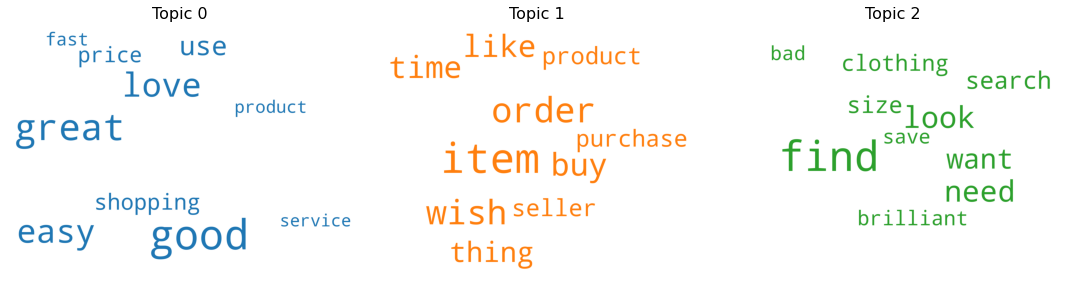

In [46]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(ncols=3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Interpretation**

- From the Wordcloud, the following topics can be interpretated:

  - Topic 0: Good Overall Service

  - Topic 1: Good Sellers Service 

  - Topic 2: Good Products

## Topic Charting

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.328606  0.136383       1        1  43.860354
1     -0.019464 -0.300258       2        1  42.119178
2     -0.309142  0.163875       3        1  14.020468, topic_info=       Term          Freq         Total Category  logprob  loglift
2      good  13755.000000  13755.000000  Default  30.0000  30.0000
31    great  10618.000000  10618.000000  Default  29.0000  29.0000
38     love   8547.000000   8547.000000  Default  28.0000  28.0000
43     easy   8353.000000   8353.000000  Default  27.0000  27.0000
54     find   2394.000000   2394.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
139    need    979.909162   1559.044574   Topic3  -3.5694   1.5003
1415    fit    267.318575    326.733251   Topic3  -4.8684   1.7639
197   money    273.657531    617.116809   Topic3  -4.8449   1.1515
421    star    202.543191    384.719174   Topic3  -5.1459   1.3231
21      new    197.834084    467.593971   Topic3  -5.1694   1.1045

[156 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
946       3  0.996375   absolutely
615       3  0.995662       addict
257       1  0.999171      amazing
290       1  0.995963  application
275       2  0.998751       arrive
...     ...       ...          ...
247       2  0.999378         well
164       2  0.999734         wish
381       2  0.999132         work
70        2  0.998972         year
217       3  0.992101          yes

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Insert Topic Name into Data

In [48]:
df_positive_topic['Dominant_Topic'] = df_positive_topic['Dominant_Topic'].map({0: 'Good Overall Service',
                                                                               1: 'Good Seller Service',
                                                                               2: 'Good Products'
                                                                               })
df_positive_topic['Dominant_Topic'].head()

0     Good Seller Service
1    Good Overall Service
2     Good Seller Service
3    Good Overall Service
4    Good Overall Service
Name: Dominant_Topic, dtype: object

# Topic Modeling for below average ratings (1 - 3 ratings )

## Converting to List

In [49]:
data = df[df['rating'] <= 3].clean_content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['stupid', 'bubble', 'game', 'impossible', 'tap', 'bubble', 'change', 'colour', 'shoot', 'stupid', 'recommend', 'star']]


## LDA Modelling

In [50]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           chunksize = 1000,
                                           passes = 15,
                                           alpha = 'asymmetric')

pprint(lda_model.print_topics())

[(0,
  '0.018*"item" + 0.013*"update" + 0.013*"good" + 0.012*"time" + '
  '0.012*"product" + 0.011*"use" + 0.011*"work" + 0.011*"like" + '
  '0.010*"search" + 0.010*"price"'),
 (1,
  '0.044*"order" + 0.029*"item" + 0.019*"refund" + 0.019*"service" + '
  '0.018*"customer" + 0.018*"receive" + 0.017*"seller" + 0.015*"time" + '
  '0.015*"money" + 0.014*"month"'),
 (2,
  '0.063*"account" + 0.025*"listing" + 0.016*"sell" + 0.015*"user" + '
  '0.012*"fake" + 0.012*"suspend" + 0.011*"team" + 0.010*"seller" + '
  '0.009*"report" + 0.009*"feedback"')]


## Categorizing sorted Data

In [51]:
df_topic_negative_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_negative_topic = df_topic_negative_keywords.reset_index()
df_negative_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_negative_topic['Document_No'] = df[df['rating'] <= 3].index
df_negative_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0           11             0.0              0.9577   
1           40             0.0              0.9189   
2           69             1.0              0.9762   
3          122             0.0              0.6389   
4          139             1.0              0.6777   
5          140             0.0              0.4617   
6          151             0.0              0.9723   
7          174             0.0              0.9227   
8          177             0.0              0.8653   
9          209             1.0              0.9523   

                                            Keywords  \
0  item, update, good, time, product, use, work, ...   
1  item, update, good, time, product, use, work, ...   
2  order, item, refund, service, customer, receiv...   
3  item, update, good, time, product, use, work, ...   
4  order, item, refund, service, customer, receiv...   
5  item, update, good, time, product, use, work, ...   
6  item, update, good, time, product, use, work, ...   
7  item, update, good, time, product, use, work, ...   
8  item, update, good, time, product, use, work, ...   
9  order, item, refund, service, customer, receiv...   

                                                Text  
0  [stupid, bubble, game, impossible, tap, bubble...  
1  [recent, update, shoppe, bubble, game, unplaya...  
2  [come, contact, live, chat, rep, purposely, wa...  
3  [aware, manage, beat, claim, certain, voucher,...  
4  [delete, account, receive, defective, item, se...  
5  [team, hopeless, usual, send, life, friend, bu...  
6  [hi, hard, shoot, bubble, play, bubble, pron, ...  
7    [force, close, time, hope, improvement, update]  
8                               [dumb, login, issue]  
9  [poor, customer, service, return, policy, sell...

## WordCloud Visualization

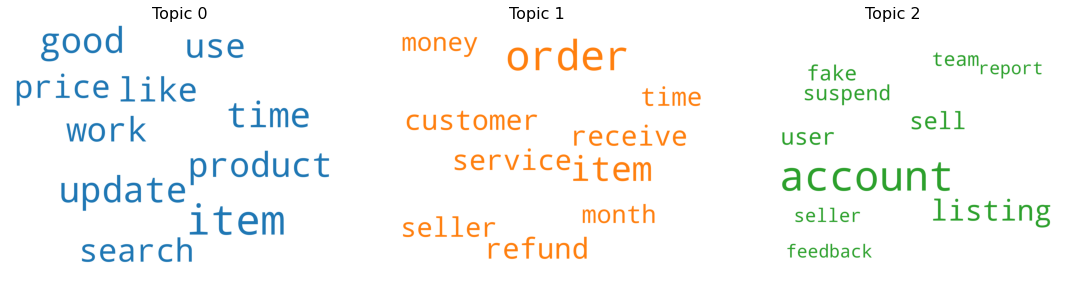

In [52]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(ncols=3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Interpretation**

- From the Wordcloud, the following topics can be interpretated:

  - Topic 0: App Issues
    
  - Topic 1: Bad Customer Service

  - Topic 2: Bad Seller Reviews

## Topic Charting

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.150279  0.181288       1        1  47.657981
1     -0.174311 -0.172556       2        1  42.545187
2      0.324590 -0.008733       3        1   9.796833, topic_info=          Term         Freq        Total Category  logprob  loglift
294      order  3178.000000  3178.000000  Default  30.0000  30.0000
77     account  1133.000000  1133.000000  Default  29.0000  29.0000
92      refund  1396.000000  1396.000000  Default  28.0000  28.0000
48     service  1364.000000  1364.000000  Default  27.0000  27.0000
78    customer  1320.000000  1320.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
96      seller   164.406991  1442.023157   Topic3  -4.6233   0.1517
1419     block    64.502499   105.933971   Topic3  -5.5589   1.8270
213      allow    79.671659   288.173739   Topic3  -5.3477   1.0375
367       list    81.511846   410.627641   Topic3  -5.3249   0.7062
693       year    71.852215   474.689276   Topic3  -5.4510   0.4351

[188 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
77        2  0.074113   account
77        3  0.925533   account
454       3  0.994084    active
427       3  0.973664  activity
407       1  0.999509        ad
...     ...       ...       ...
115       1  0.999201      work
693       1  0.452928      year
693       2  0.396049      year
693       3  0.151678      year
6809      3  0.968523        假货

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Insert Topic Name into Data

In [54]:
df_negative_topic['Dominant_Topic'] = df_negative_topic['Dominant_Topic'].map({0: 'App Issues',
                                                                               1: 'Bad Customer Service',
                                                                               2: 'Bad Seller Reviews',
                                                                               })
df_negative_topic['Dominant_Topic'].head()

0              App Issues
1              App Issues
2    Bad Customer Service
3              App Issues
4    Bad Customer Service
Name: Dominant_Topic, dtype: object

## Combining topic category with df

In [55]:
topics_df = pd.concat([df_positive_topic, df_negative_topic], ignore_index = True).set_index('Document_No').sort_index()

In [56]:
topics_df.shape

(74685, 4)

In [57]:
df['category'] = topics_df['Dominant_Topic']

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74685 entries, 0 to 74684
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rating          74685 non-null  int64         
 1   date            74685 non-null  datetime64[ns]
 2   app             74685 non-null  object        
 3   store           74685 non-null  object        
 4   review          74685 non-null  object        
 5   clean_content   74685 non-null  object        
 6   adj             60252 non-null  object        
 7   noun            52629 non-null  object        
 8   verb            42763 non-null  object        
 9   emoji           4701 non-null   object        
 10  neg_score       74685 non-null  float64       
 11  neu_score       74685 non-null  float64       
 12  pos_score       74685 non-null  float64       
 13  compound_score  74685 non-null  float64       
 14  month           74685 non-null  int64         
 15  da

# EDA for LDA Topics

## Distribution Across Topics

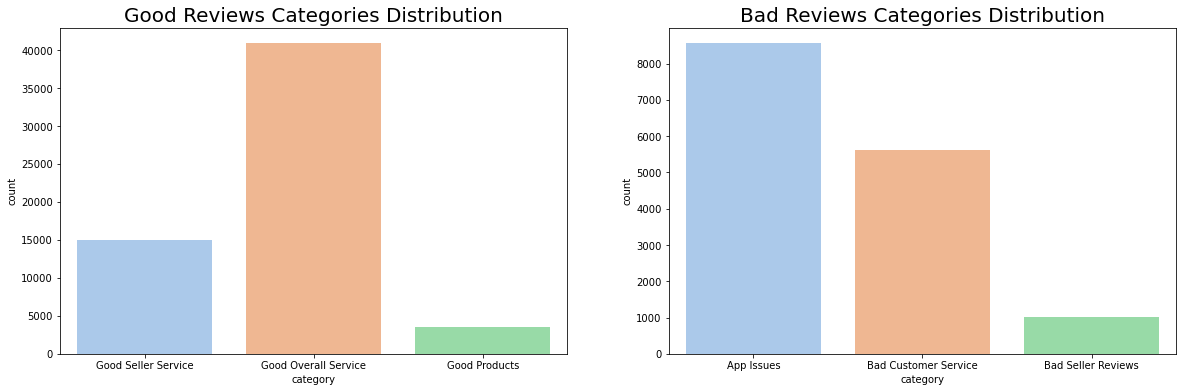

In [59]:
fig, ax = plt.subplots(1,2, figsize = (20, 6))
sns.countplot(x = 'category', data = df[df['rating'] > 3], order = df.category.unique().sort(), ax = ax[0])
ax[0].set_title('Good Reviews Categories Distribution', fontsize = 20)
sns.countplot(x = 'category', data = df[df['rating'] <= 3], order = df.category.unique().sort(), ax = ax[1])
ax[1].set_title('Bad Reviews Categories Distribution', fontsize = 20);

**Remarks**
- Most good reviews are about App Quality
- Most bad reviews are about Bad Customer Service

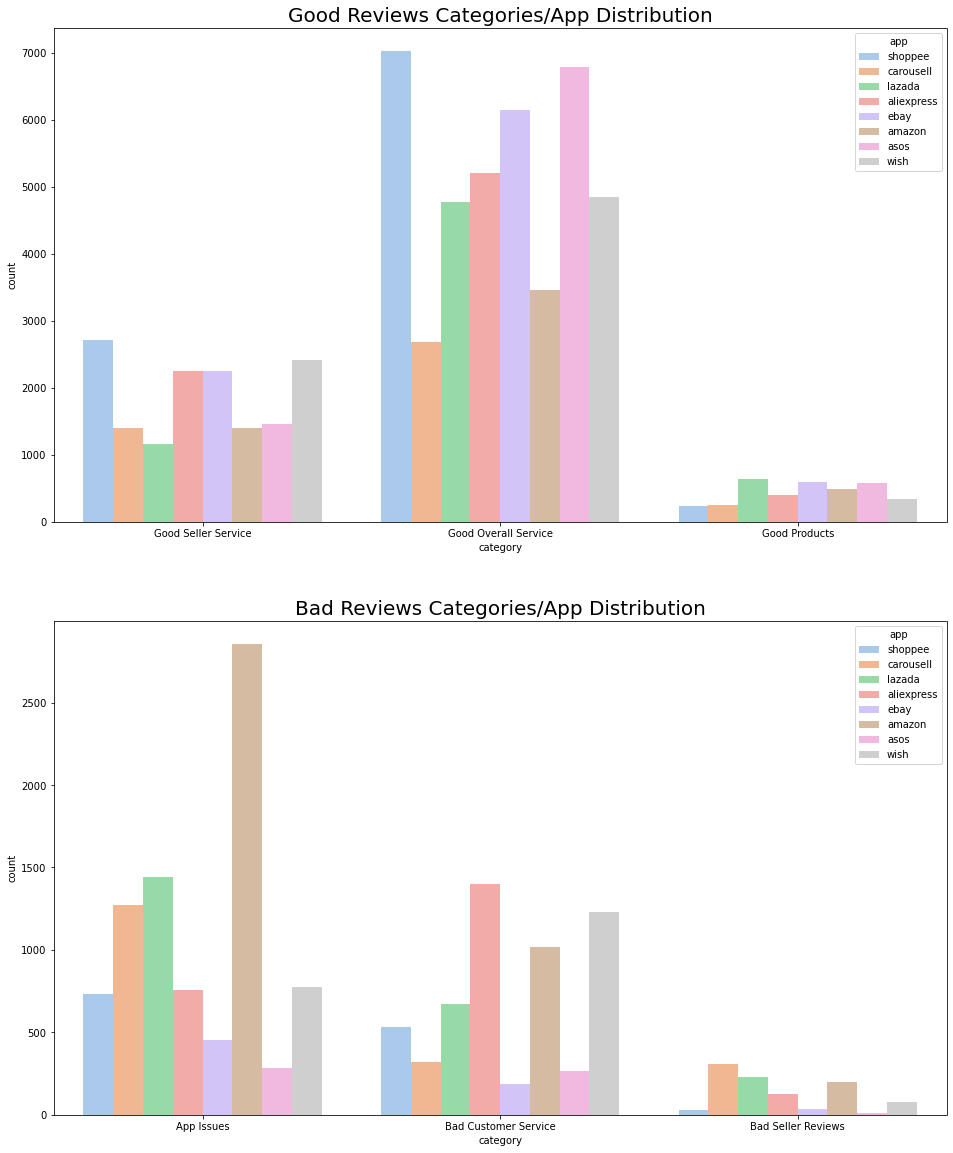

In [60]:
fig, ax = plt.subplots(2,1, figsize = (16, 20))
sns.countplot(x = 'category', hue = 'app', data = df[df['rating'] > 3], order = df.category.unique().sort(), ax = ax[0])
ax[0].set_title('Good Reviews Categories/App Distribution', fontsize = 20)

sns.countplot(x = 'category', hue = 'app', data = df[df['rating'] <= 3], order = df.category.unique().sort(), ax = ax[1])
ax[1].set_title('Bad Reviews Categories/App Distribution', fontsize = 20);

**Remarks**
- Amazon seems to take the lead in having more bad reviews as compared to the other apps
- Shoppee and ASOS takes the lead in App Quality for good reviews

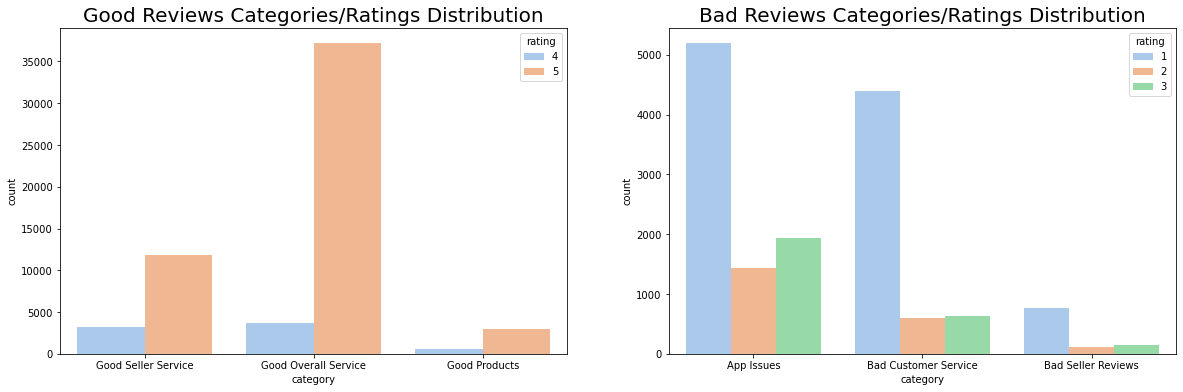

In [61]:
fig, ax = plt.subplots(1,2, figsize = (20, 6))
sns.countplot(x = 'category', hue = 'rating', data = df[df['rating'] > 3], order = df.category.unique().sort(), ax = ax[0])
ax[0].set_title('Good Reviews Categories/Ratings Distribution', fontsize = 20)

sns.countplot(x = 'category', hue = 'rating', data = df[df['rating'] <= 3], order = df.category.unique().sort(), ax = ax[1])
ax[1].set_title('Bad Reviews Categories/Ratings Distribution', fontsize = 20);

**Remarks**
- Users the wants to give a bad review will tend to just give a 1 rating
- Users that wants to give a good review will tend to just give a 5 rating

## Distribution of Rating for Month and Week

In [62]:
def plot_countplots_time_cat(df, date_features, scoring):
    nrows = int(np.ceil(len(date_features)))
    fig,ax = plt.subplots(nrows,1, figsize = (15, 6*nrows))
    
    for i in range(len(date_features)):
        ax[i].set_title(f'Count of {date_features[i]} across Shopping reviews {scoring}', fontdict = {'fontsize': 20})
        g = sns.countplot(x = date_features[i] , data = df, ax=ax[i], color = 'grey')
        g2 = g.twinx()
        
        g2 = sns.pointplot(x = date_features[i],
                           y = scoring,
                           hue = 'category',
                           data = df,
                           errwidth = 0,
                           ax=g2)
        
        plt.legend()
    plt.show()

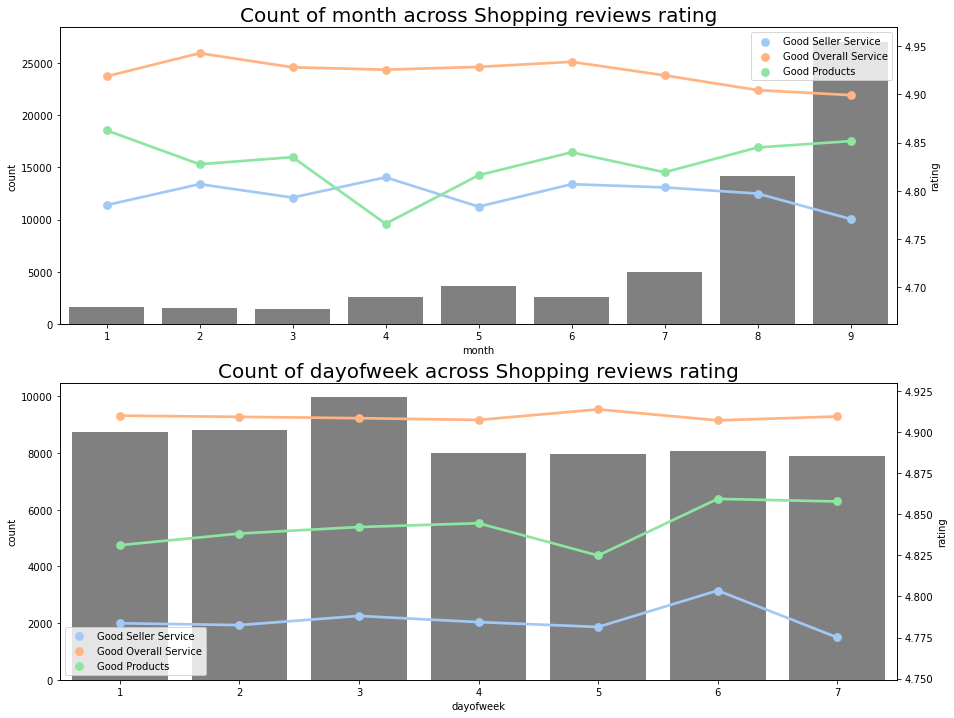

In [63]:
plot_countplots_time_cat(df[df['rating'] >3] , ['month', 'dayofweek'], 'rating')

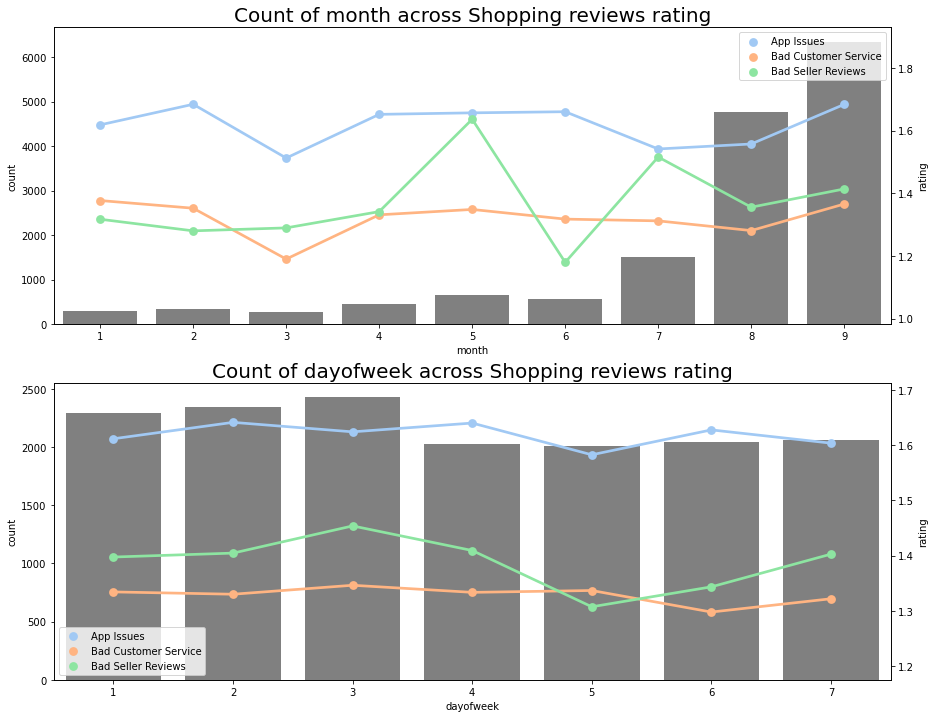

In [64]:
plot_countplots_time_cat(df[df['rating'] <= 3] , ['month', 'dayofweek'], 'rating')

## Distribution of Compound Score for Month and Week

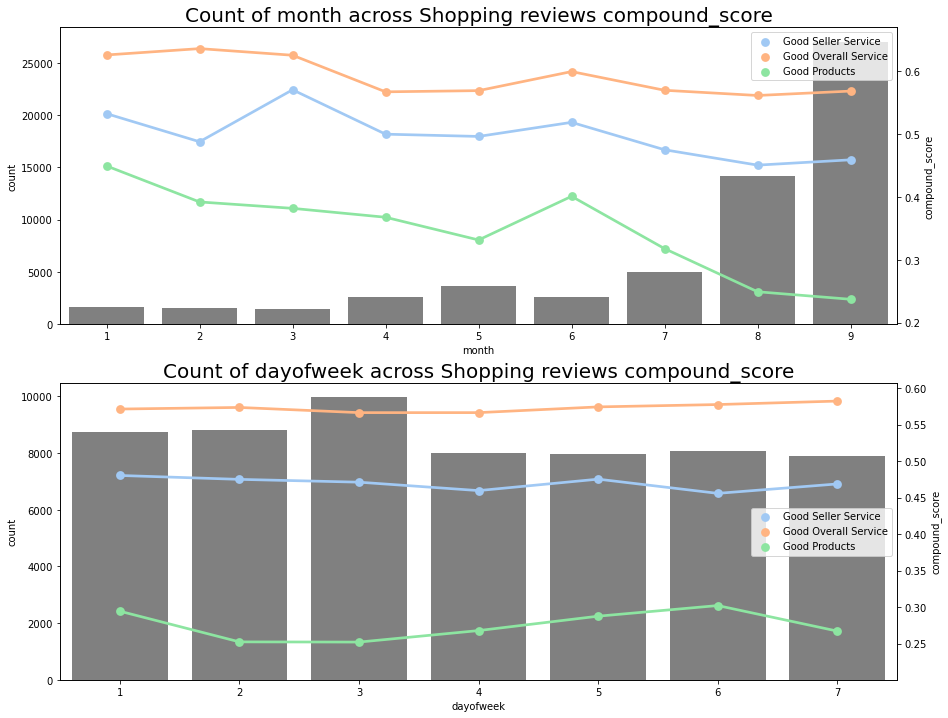

In [65]:
plot_countplots_time_cat(df[df['rating'] > 3] , ['month', 'dayofweek'], 'compound_score')

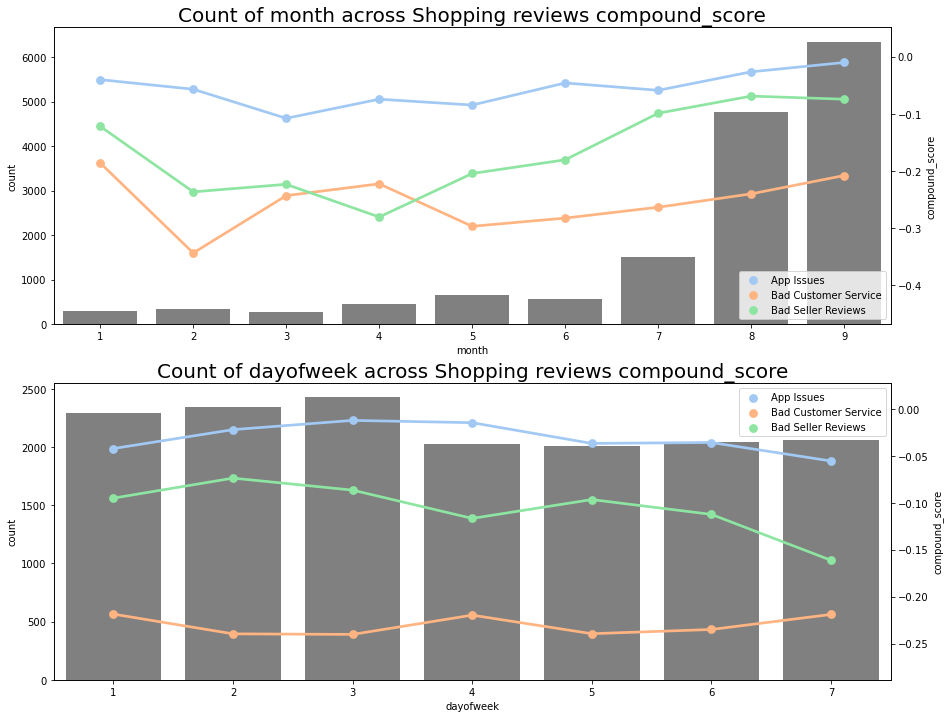

In [66]:
plot_countplots_time_cat(df[df['rating'] <= 3] , ['month', 'dayofweek'], 'compound_score')

**Remarks**
- There is a slight dip in Delivery Reviews in the month of March, we coincided with the period where people are confined at home due to covid.
- This could be because of the delivery company unable to fufill the spike in demand for delivery
- which caused the increase in bad ratings, especially in delivery sector
- Delivery comments also takes a dip on Tuesday, and more significantly on Fridays, which could be days people are expecting their purchase but did not receive them

# Exporting Data for Modelling

In [67]:
df.to_csv('../data/reviews_Model.csv', index=None, header=True)